## Descargamos y extraemos el dataset BirdsDataset.zip

In [1]:
!wget https://www.dropbox.com/s/ej3lr5v04xl9f3f/BirdsDataset.zip?dl=0 -O BirdsDataset.zip

--2019-05-14 14:28:07--  https://www.dropbox.com/s/ej3lr5v04xl9f3f/BirdsDataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ej3lr5v04xl9f3f/BirdsDataset.zip [following]
--2019-05-14 14:28:08--  https://www.dropbox.com/s/raw/ej3lr5v04xl9f3f/BirdsDataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8abd2a1dbd8d95b96a1cae6277.dl.dropboxusercontent.com/cd/0/inline/Ag7pQbx4c17f-ZpCOc_BYW4JQR7tHmTNgNK9vupqbLLFSVwSIRJrqJo_btzuUcRG-BXZveDmGiEAPObEQdGdSVQNLL-wpCBOBzsjcTGUEgiCOg/file# [following]
--2019-05-14 14:28:08--  https://uc8abd2a1dbd8d95b96a1cae6277.dl.dropboxusercontent.com/cd/0/inline/Ag7pQbx4c17f-ZpCOc_BYW4JQR7tHmTNgNK9vupqbLLFSVwSIRJrqJo_btzuUcRG-BXZveDmGiEAPObEQdGdSVQNLL-wpCBOBzsjcTGUEgiCOg/file
Re

In [ ]:
!unzip BirdsDataset.zip

In [7]:
!ls BirdsDataset/CUB_200_2011/

test  train  val


# Actividad 1

In [1]:
import os
import time
import copy
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
def train_model(model, criterion, optimizer, scheduler, history, dataloaders, dataset_sizes, device, num_epochs,
                best_train_acc=0.0, best_val_acc=0.0):
    
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    num_epochs_before = len(history['train_loss'])
    
    for epoch in range(num_epochs_before, num_epochs_before + num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs_before + num_epochs - 1))
        print('-' * 10)
        
        for phase in ('train', 'val'):
            
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_acc = 0
            epoch_since = time.time()
                
            with torch.set_grad_enabled(phase == 'train'):                
                
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    optimizer.zero_grad()                    
                    
                    # forward pass
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward pass + optimization only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_acc += torch.sum(preds == labels.data)
                    
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = float(running_acc.double() / dataset_sizes[phase])
            
            history['%s_loss' % phase].append(epoch_loss)
            history['%s_acc' % phase].append(epoch_acc)

            print('[{}]\tLoss: {:.4f} Acc: {:.4f} Secs: {:.2f}'.format(
                phase, epoch_loss, epoch_acc, time.time() - epoch_since))
            
            if phase == 'val':
                
                scheduler.step(epoch_acc) # update learning rate if necessary
                
                if epoch_acc > best_val_acc or (
                        epoch_acc == best_val_acc and\
                        last_train_acc > best_train_acc): # improvement detected!
                    
                    # update best train and val accuracies
                    best_val_acc = epoch_acc
                    best_train_acc = last_train_acc
                    
                    # deep copy the model
                    best_model_wts = copy.deepcopy(model.state_dict())
                    
                    print('\t*** improvement detected! best_val_acc=%f, best_train_acc=%f' % (
                        best_val_acc, best_train_acc))
                                                
            else:                
                last_train_acc = epoch_acc
                                                
                
        print()

    elapsed_time = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        elapsed_time // 60, elapsed_time % 60))
    print('Best val acc: {:4f}'.format(best_val_acc))

    
    return dict(
        best_model_wts=best_model_wts,
        best_val_acc=best_val_acc,
        best_train_acc=best_train_acc,
    )

In [27]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './BirdsDataset/CUB_200_2011/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [6]:
model = torchvision.models.resnet50()
model.fc = nn.Linear(2048, len(class_names))
model = model.to(device)

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

In [47]:
checkpoint_path = './model.pth'
try:
    checkpoint = torch.load(checkpoint_path)
    history = checkpoint['history']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_val_acc = checkpoint['best_val_acc']
    best_train_acc = checkpoint['best_train_acc']
    print('model successfully loaded from checkpoint!')    
    print('\tbest_val_acc = ', best_val_acc)
    print('\tbest_train_acc = ', best_train_acc)
    print('\tepochs already trained = ', len(history['train_loss']))
except FileNotFoundError:
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    best_val_acc = 0.0
    best_train_acc = 0.0

model successfully loaded from checkpoint!
	best_val_acc =  0.4277056277056277
	best_train_acc =  0.9409901826243007
	epochs already trained =  151


In [42]:
# ---- OPTIONAL: set optimizer's learning rate to a different value
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-4

In [43]:
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=4, verbose=True)

In [48]:
result = train_model(model, criterion, scheduler, optimizer, history,
                     dataloaders, dataset_sizes, device,                     
                     best_val_acc=best_val_acc,
                     best_train_acc=best_train_acc,
                     num_epochs=39,
                    )

Epoch 151/189
----------
[train]	Loss: 0.1839 Acc: 0.9520 Secs: 50.84
[val]	Loss: 3.7694 Acc: 0.4199 Secs: 2.35

Epoch 152/189
----------
[train]	Loss: 0.1690 Acc: 0.9556 Secs: 50.93
[val]	Loss: 3.8012 Acc: 0.4329 Secs: 2.29
	*** improvement detected! best_val_acc=0.432900, best_train_acc=0.955558

Epoch 153/189
----------
[train]	Loss: 0.1662 Acc: 0.9559 Secs: 50.95
[val]	Loss: 3.6894 Acc: 0.4156 Secs: 2.39

Epoch 154/189
----------
[train]	Loss: 0.1688 Acc: 0.9527 Secs: 50.94
[val]	Loss: 3.9262 Acc: 0.4182 Secs: 2.33

Epoch 155/189
----------
[train]	Loss: 0.1738 Acc: 0.9521 Secs: 50.94
[val]	Loss: 3.7935 Acc: 0.4156 Secs: 2.33

Epoch 156/189
----------
[train]	Loss: 0.1645 Acc: 0.9605 Secs: 50.95
[val]	Loss: 3.9312 Acc: 0.4104 Secs: 2.34

Epoch 157/189
----------
[train]	Loss: 0.1614 Acc: 0.9564 Secs: 50.95
[val]	Loss: 3.7096 Acc: 0.4234 Secs: 2.34
Epoch    45: reducing learning rate of group 0 to 1.1765e-05.

Epoch 158/189
----------
[train]	Loss: 0.1680 Acc: 0.9563 Secs: 51.06
[va

In [49]:
checkpoint = dict(
    best_model_state_dict = result['best_model_wts'],
    best_val_acc = result['best_val_acc'],
    best_train_acc = result['best_train_acc'],
    history = history,
    model_state_dict = model.state_dict(),
    optimizer_state_dict = optimizer.state_dict(),
)
torch.save(checkpoint, checkpoint_path)

In [50]:
!ls -lh ./model.pth

-rw-rw-r-- 1 pamessina pamessina 366M May 14 23:56 ./model.pth


In [35]:
import matplotlib.pyplot as plt

def plot_train_val_curves(checkpoint_path, figsize=(10, 6)):
    checkpoint = torch.load(checkpoint_path)
    history = checkpoint['history']
    epochs = list(range(len(history['train_loss'])))
    
    plt.figure(figsize=figsize)
    
    plt.subplot(121)
    plt.title('Loss per epoch')
    plt.plot(epochs, history['train_loss'], label='train_loss')
    plt.plot(epochs, history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(122)
    plt.title('Accuracy per epoch')
    plt.plot(epochs, history['train_acc'], label='train_acc')
    plt.plot(epochs, history['val_acc'], label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')    
    best_val_acc, best_val_i = max((a,i) for i,a in enumerate(history['val_acc']))
    plt.hlines(best_val_acc, 0, len(epochs), colors=('red',), linestyles='dashed',
               label='best_val_acc=%.3f, epoch=%d' % (best_val_acc, best_val_i))
    best_train_acc, best_train_i = max((a,i) for i,a in enumerate(history['train_acc']))
    plt.hlines(best_train_acc, 0, len(epochs), colors=('green',), linestyles='dashed',
               label='best_train_acc=%.3f, epoch=%d' % (best_train_acc, best_train_i))
    
    plt.legend()
    
    plt.show()

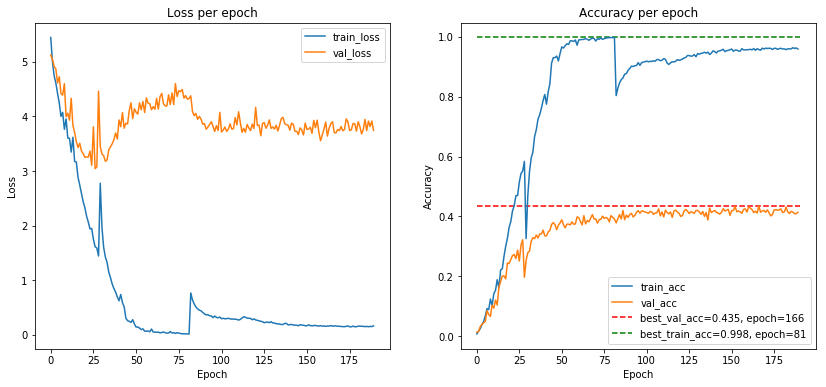

In [81]:
plot_train_val_curves('./model.pth', figsize=(14,6))

Arriba están las curvas de loss por epoch y accuracy por epoch para entrenamiento y validación, luego de haber entrenado el modelo por más de 180 épocas. Primero notamos que existe una clara distancia entre train y val, lo cual es indicativo de overfitting (el modelo se está aprendiendo bastante bien el train pero no está generalizando tan bien a val).
Si nos fijamos en lo sucedido hasta la época 81, el modelo llegó a un máximo de 99.8% accuracy en train, un rendimiento casi perfecto, sin embargo en validación el modelo no logró progresar mucho más del 40%. Debido a este gap, tomé la decisión de hacer un data augmentation un poco más intenso con la expectativa de reducir el overfitting y aumentar la generalización. Como resultado la accuracy en train cayó abruptamente y el modelo empezó a aprender nuevamente, con lo cual se alcanzó un máximo en validación de 43.5% en la época 166. Esto confirma que el data augmentation es útil hasta un cierto punto, pero de todas maneras sigue habiendo un enorme gap entre train y val.

In [36]:
def test_model(model, checkpoint_path, dataloader, dataset_size, device):            
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['best_model_state_dict'])            
    model.eval()
    running_acc = 0
    with torch.set_grad_enabled(False):                
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_acc += torch.sum(preds == labels.data)
    accuracy = float(running_acc.double() / dataset_size)
    return accuracy

In [66]:
test_accuracy = test_model(model, './model.pth', dataloaders['test'], dataset_sizes['test'], device)

In [67]:
test_accuracy

0.41465517241379307

Como vemos, en el set de test el resultado del mejor modelo es 41.47%, muy cercano y consistente con el 43.5% obtenido en validación. Esto confirma que el modelo generaliza con un accuracy ligeramente superior a 40% a imágenes de la misma distribución pero que no ha visto durante entrenamiento.

# Actividad 2

In [5]:
model_ft = torchvision.models.resnet50(pretrained=True)
model_ft.fc = nn.Linear(2048, len(class_names))
model_ft = model_ft.to(device)
optimizer_ft = optim.Adam(model_ft.parameters())
criterion_ft = nn.CrossEntropyLoss()

In [33]:
checkpoint_path = './model_ft.pth'
try:
    checkpoint_ft = torch.load(checkpoint_path)
    history_ft = checkpoint['history']
    model_ft.load_state_dict(checkpoint['model_state_dict'])
    optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
    best_val_acc = checkpoint['best_val_acc']
    best_train_acc = checkpoint['best_train_acc']
    print('model successfully loaded from checkpoint!')    
    print('\tbest_val_acc = ', best_val_acc)
    print('\tbest_train_acc = ', best_train_acc)
    print('\tepochs already trained = ', len(history_ft['train_loss']))
except FileNotFoundError:
    history_ft = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    best_val_acc = 0.0
    best_train_acc = 0.0

model successfully loaded from checkpoint!
	best_val_acc =  0.703030303030303
	best_train_acc =  0.9904993138393329
	epochs already trained =  160


In [34]:
# ---- OPTIONAL: set optimizer's learning rate to a different value
for param_group in optimizer_ft.param_groups:
    param_group['lr'] = 1e-4

In [35]:
scheduler_ft = ReduceLROnPlateau(optimizer_ft, mode='max', factor=0.7, patience=4, verbose=True)

In [36]:
result = train_model(model_ft, criterion_ft, optimizer_ft,
                     scheduler_ft, history_ft,
                     dataloaders, dataset_sizes, device,
                     best_val_acc=best_val_acc,
                     best_train_acc=best_train_acc,
                     num_epochs=50,
                    )

Epoch 160/209
----------
[train]	Loss: 0.0479 Acc: 0.9930 Secs: 50.35
[val]	Loss: 1.5875 Acc: 0.6970 Secs: 2.33

Epoch 161/209
----------
[train]	Loss: 0.0345 Acc: 0.9958 Secs: 50.62
[val]	Loss: 1.5835 Acc: 0.7056 Secs: 2.38
	*** improvement detected! best_val_acc=0.705628, best_train_acc=0.995777

Epoch 162/209
----------
[train]	Loss: 0.0304 Acc: 0.9955 Secs: 50.73
[val]	Loss: 1.5527 Acc: 0.7039 Secs: 2.29

Epoch 163/209
----------
[train]	Loss: 0.0281 Acc: 0.9966 Secs: 50.76
[val]	Loss: 1.5671 Acc: 0.7004 Secs: 2.30

Epoch 164/209
----------
[train]	Loss: 0.0252 Acc: 0.9965 Secs: 50.77
[val]	Loss: 1.5215 Acc: 0.7169 Secs: 2.38
	*** improvement detected! best_val_acc=0.716883, best_train_acc=0.996516

Epoch 165/209
----------
[train]	Loss: 0.0285 Acc: 0.9964 Secs: 50.77
[val]	Loss: 1.5341 Acc: 0.7100 Secs: 2.42

Epoch 166/209
----------
[train]	Loss: 0.0227 Acc: 0.9970 Secs: 50.88
[val]	Loss: 1.5417 Acc: 0.7082 Secs: 2.29

Epoch 167/209
----------
[train]	Loss: 0.0240 Acc: 0.9968 Sec

In [37]:
checkpoint = dict(
    best_model_state_dict = result['best_model_wts'],
    best_val_acc = result['best_val_acc'],
    best_train_acc = result['best_train_acc'],
    history = history_ft,
    model_state_dict = model_ft.state_dict(),
    optimizer_state_dict = optimizer_ft.state_dict(),
)
torch.save(checkpoint, checkpoint_path)

In [38]:
!ls -lh ./model_ft.pth

-rw-rw-r-- 1 pamessina pamessina 366M May 19 18:44 ./model_ft.pth


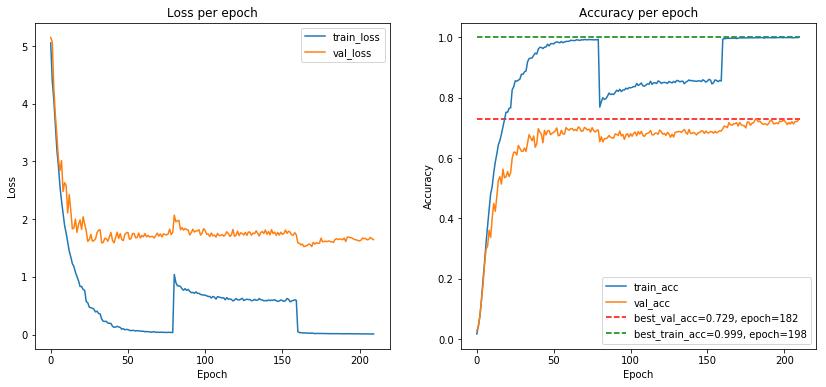

In [39]:
plot_train_val_curves('./model_ft.pth', figsize=(14,6))

Arriba están las curvas de loss por epoch y accuracy por epoch para entrenamiento y validación, luego de haber entrenado el modelo por 210 épocas. Primero notamos que sigue existiendo una clara distancia entre train y val, lo cual es indicativo de overfitting. Sin embargo, notamos que el overfitting con fine-tuning es mucho menor al overfitting entrenando desde 0. Mientras que partiendo desde 0 se logró un accuracy máximo de 43.5% en validación, partiendo con los pesos pre-entrenados en imagenet se logró un accuracy máximo de 72.9% en validación, es decir casi 30% más de accuracy. Esto demuestra lo importante que es la inicialización de los pesos de la red para aumentar las chances de encontrar una hipótesis que generalice bien (al menos cuando el set de entrenamiento es pequeño). Las perturbaciones bruscas que vemos en la curvas de train y val entre las épocas 80 y 160 aprox. se deben a que en ese tramo probé usar un data augmentation más extremo, pero al final terminó siendo más perjudicial que benificioso debido a que se mete demasiado ruido al entrenar. De la época 160 en adelante usé un data augmentation más suave, con el cual se alcanzó el máximo de 72.9% en validación.

In [41]:
test_accuracy = test_model(model_ft, './model_ft.pth', dataloaders['test'], dataset_sizes['test'], device)

In [42]:
test_accuracy

0.7077586206896551

Como vemos, en el set de test el resultado del mejor modelo es 70.78%, muy cercano y consistente con el 72.9% obtenido en validación. Esto confirma que el modelo generaliza con un accuracy ligeramente superior a 70% a imágenes de la misma distribución pero que no ha visto durante entrenamiento.

# Actividad 3

In [16]:
from textwrap import wrap
import matplotlib.pyplot as plt
import math

def plot_images(image_paths, labels, label_colors=None, max_cols=3):
    assert len(image_paths) == len(labels)
    plt.close()
    n = len(image_paths)
    nrows = math.ceil(n/max_cols)
    ncols = min(n, max_cols)
    plt.figure(1, (16, 5 * nrows))
    for i, (path, label) in enumerate(zip(image_paths, labels)):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xlabel(label, fontsize=16)
        if label_colors is not None:
            ax.xaxis.label.set_color(label_colors[i])
        with open(path, 'rb') as f:
            img = plt.imread(f)
        ax.imshow(img, interpolation="nearest")
    plt.show()

def show_class(class_id, class_names, class_acc, class_size, class_imgs, class_preds):
    i = class_id
    print('%s acc=%.3f size=%d' % (class_names[i], class_acc[i], class_size[i]))
    
    labels = ['\n'.join(wrap( ('(correct): ' if class_id == pred else '(incorrect): ') +\
                             class_names[pred], 24)) for pred in class_preds[i]]
    label_colors = ['green' if class_id == pred else 'red' for pred in class_preds[i]]
    plot_images(class_imgs[i], labels, label_colors)

def analyze_test_results(model, checkpoint_path, dataloader, dataset_size, class_names, device,
                         best_k=2, worst_k=2, middle_k=2):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['best_model_state_dict'])            
    model.eval()
    
    n_classes = len(class_names)
    class_acc = [0 for _ in range(n_classes)]
    class_size = [0 for _ in range(n_classes)]
    class_imgs = [[] for _ in range(n_classes)]
    class_preds = [[] for _ in range(n_classes)]
    
    running_acc = 0
    
    with torch.set_grad_enabled(False):
        for inputs, labels, paths in dataloader:
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_acc += torch.sum(preds == labels.data)    
            
            for pred_class, true_class, img in zip(preds, labels.data, paths):
                class_acc[true_class] += bool(pred_class == true_class)
                class_size[true_class] += 1
                class_imgs[true_class].append(img)
                class_preds[true_class].append(int(pred_class))
                
    accuracy = float(running_acc.double() / dataset_size)
    
    perfect_count = sum(1 for acc, size in zip(class_acc, class_size) if acc == size)
    zero_count = sum(1 for acc in class_acc if acc == 0)
    
    for i in range(n_classes):
        class_acc[i] /= class_size[i]
        
    print('#classes with 100% accuracy = ', perfect_count)
    print('#classes with 0% accuracy = ', zero_count)
    plt.title('Test Set Accuracy Histogram\n(acc = %.4f)' % accuracy)
    plt.hist(class_acc, bins=100)
    plt.show()
    
    class_ids = list(range(n_classes))
    class_ids.sort(key=lambda i : class_acc[i], reverse=True)
    
    if (best_k > 0):
        print('============================= BEST %d CLASSES ===============================' % best_k)
        for k in range(best_k):
            print()
            show_class(class_ids[k], class_names, class_acc, class_size, class_imgs, class_preds)
    
    if (middle_k > 0):
        print('\n\n============================= MIDDLE %d CLASSES ===============================' % middle_k)
        for k in range((n_classes-middle_k)//2, (n_classes-middle_k)//2 + middle_k):
            print()
            show_class(class_ids[k], class_names, class_acc, class_size, class_imgs, class_preds)
    
    if (worst_k > 0):
        print('\n\n============================= WORST %d CLASSES ===============================' % worst_k)
        for k in range(1, worst_k+1):
            print()
            show_class(class_ids[-k], class_names, class_acc, class_size, class_imgs, class_preds)

In [4]:
# source: https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (*original_tuple, path)
        return tuple_with_path

In [7]:
data_dir = './BirdsDataset/CUB_200_2011/'
test_image_dataset = ImageFolderWithPaths(os.path.join(data_dir, 'test'), data_transforms['test'])
test_dataloader = torch.utils.data.DataLoader(test_image_dataset, batch_size=64, num_workers=4)
test_size = len(test_image_dataset)
class_names = test_image_dataset.classes

In [8]:
resnet50_model = torchvision.models.resnet50()
resnet50_model.fc = nn.Linear(2048, len(class_names))
resnet50_model = resnet50_model.to(device)

### ResNet50 SIN fine-tuning

#classes with 100% accuracy =  5
#classes with 0% accuracy =  20


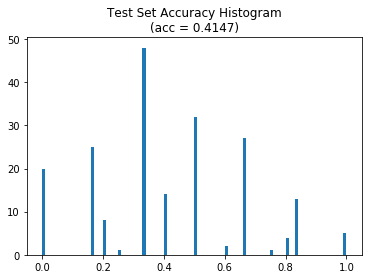

============================= BEST 2 CLASSES ===============================

042.Vermilion_Flycatcher acc=1.000 size=6


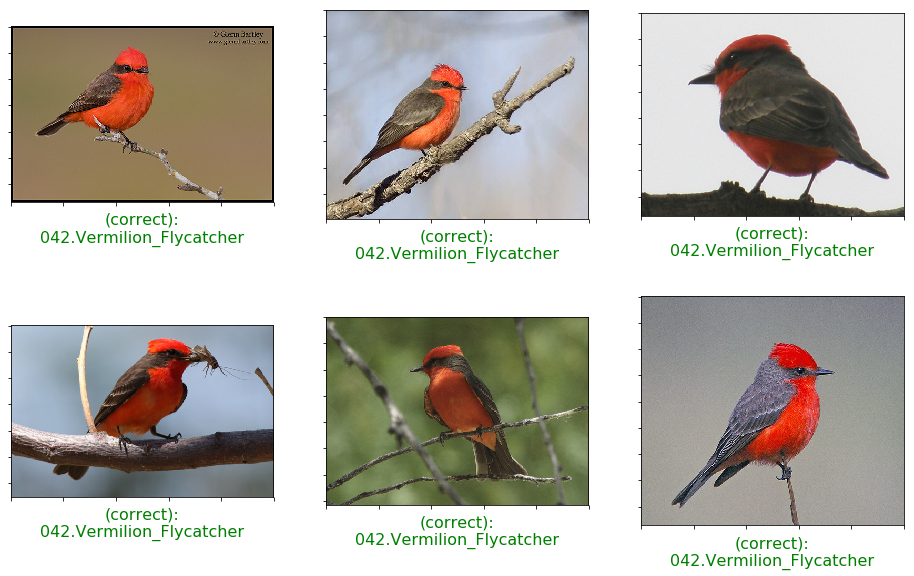


052.Pied_billed_Grebe acc=1.000 size=6


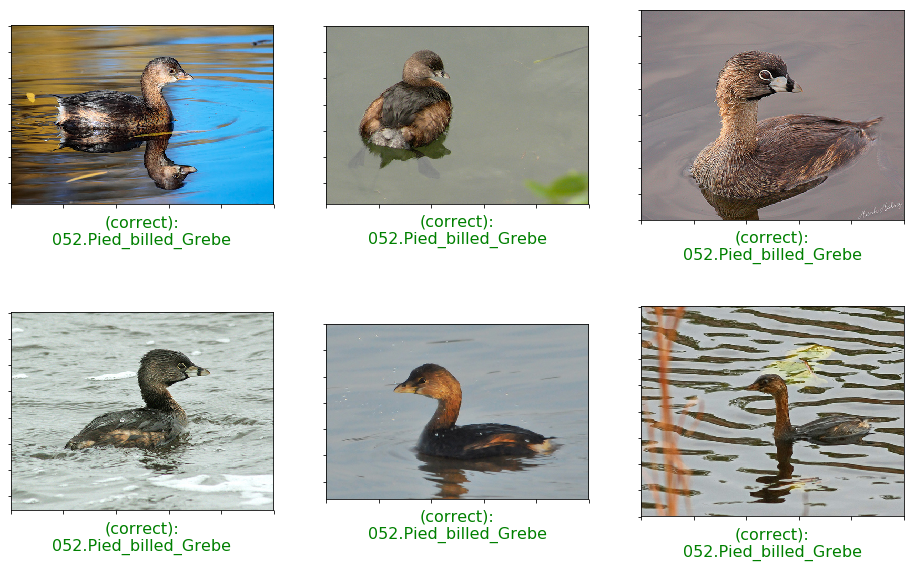



============================= WORST 2 CLASSES ===============================

179.Tennessee_Warbler acc=0.000 size=6


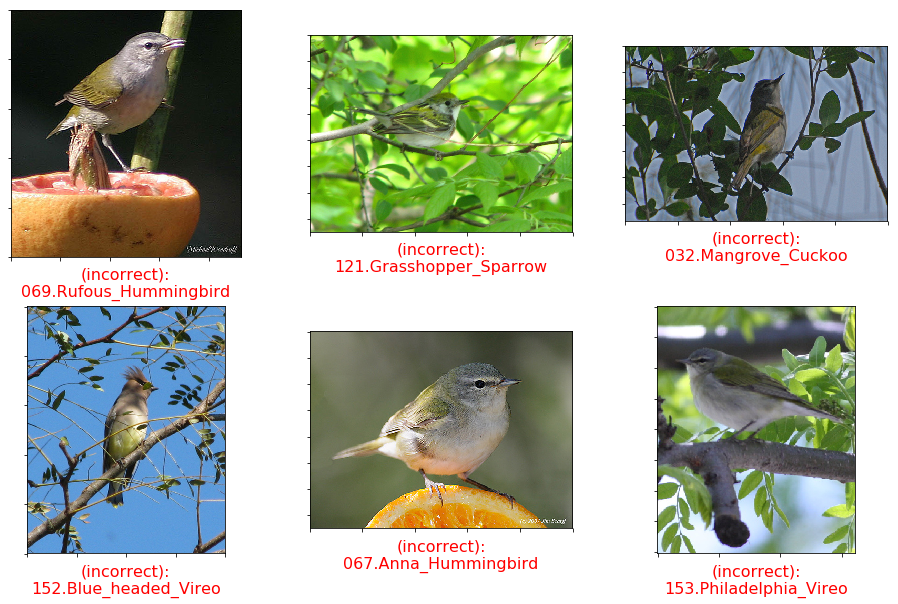


149.Brown_Thrasher acc=0.000 size=5


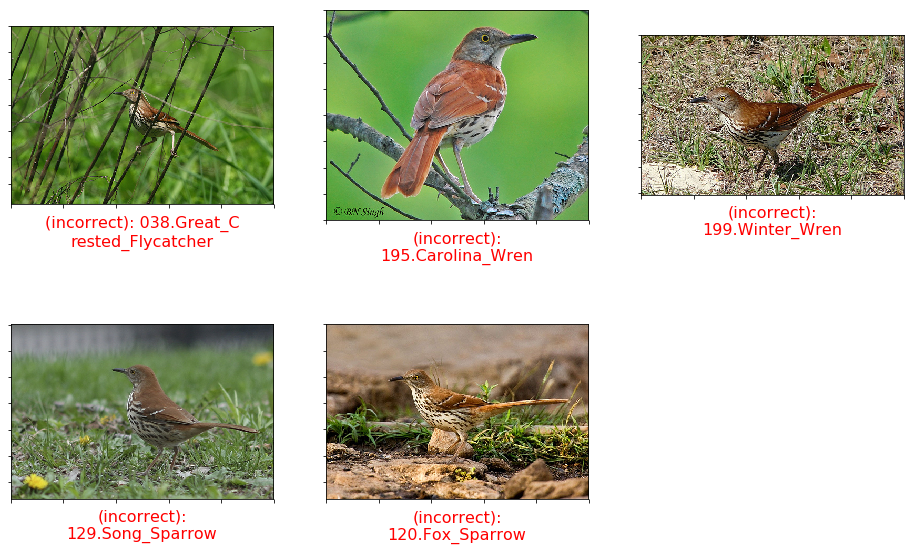

In [17]:
analyze_test_results(resnet50_model, './model.pth', test_dataloader, test_size, class_names, device,
                     best_k=2, middle_k=0, worst_k=2)

### ResNet50 CON fine-tuning

#classes with 100% accuracy =  45
#classes with 0% accuracy =  3


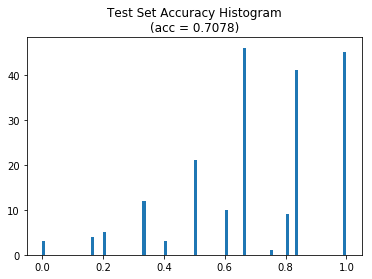

============================= BEST 2 CLASSES ===============================

007.Parakeet_Auklet acc=1.000 size=5


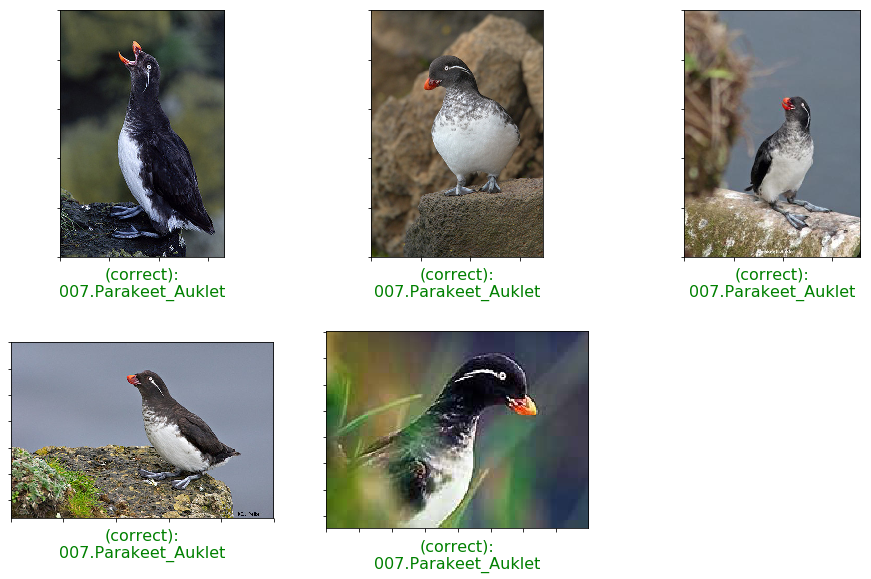


017.Cardinal acc=1.000 size=5


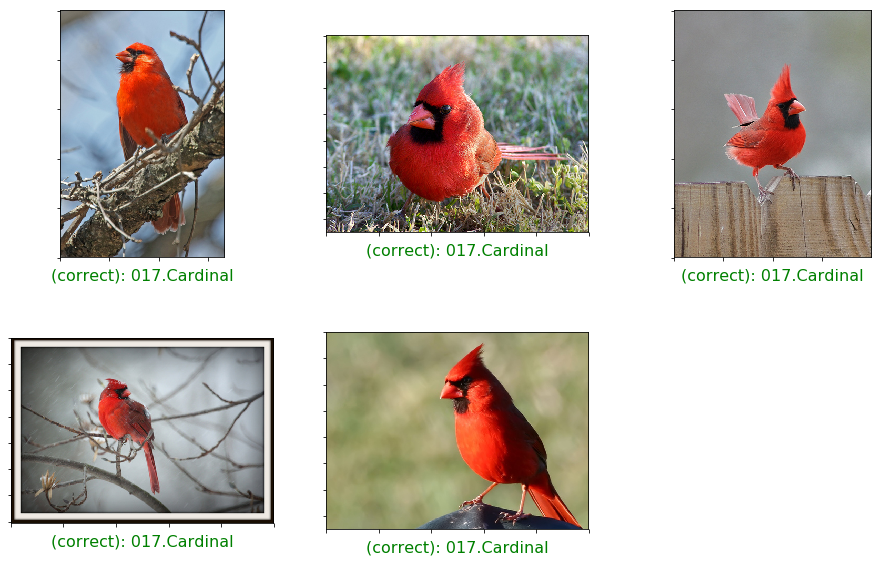



============================= WORST 2 CLASSES ===============================

062.Herring_Gull acc=0.000 size=6


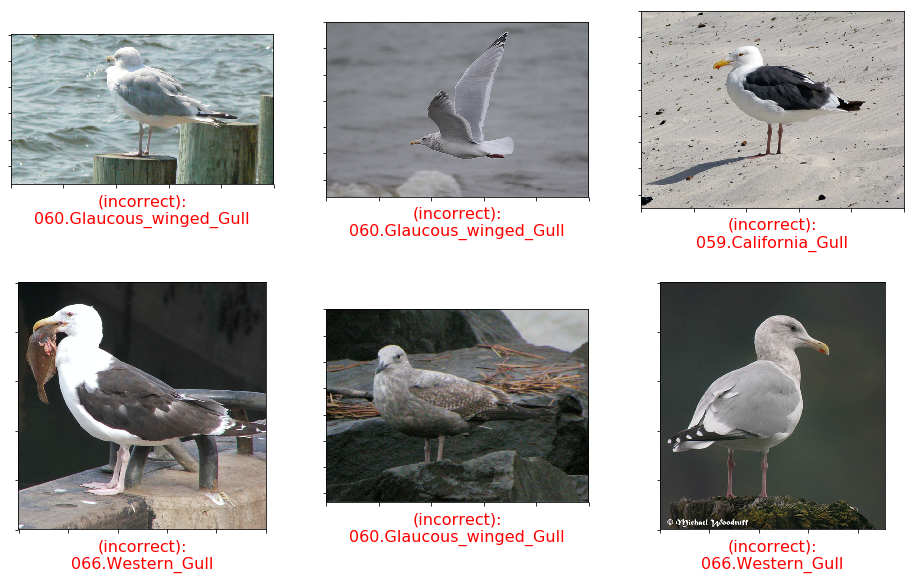


040.Olive_sided_Flycatcher acc=0.000 size=6


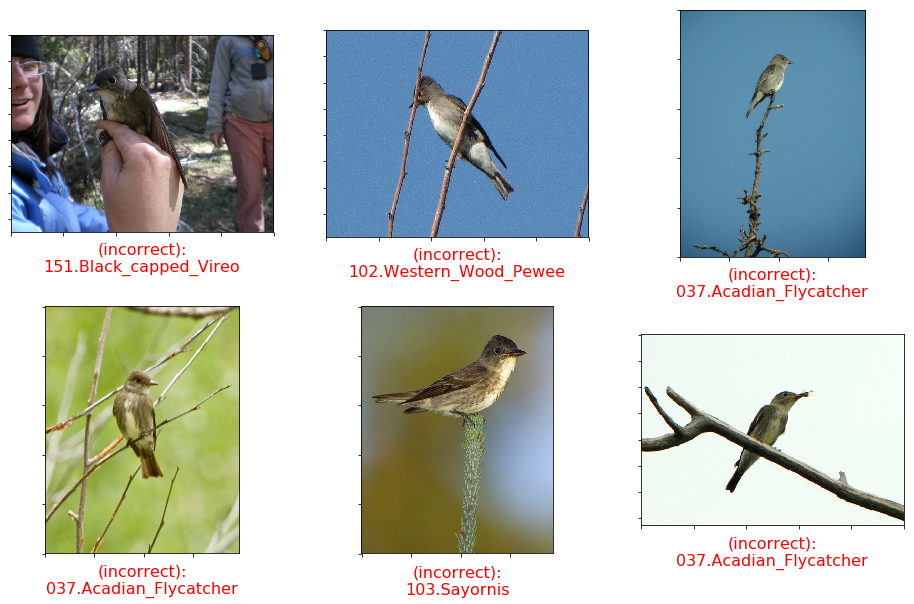

In [18]:
analyze_test_results(resnet50_model, './model_ft.pth', test_dataloader, test_size, class_names, device,
                     best_k=2, middle_k=0, worst_k=2)

## Tabla comparativa y comentarios

| Estrategia | CON fine-tuning | SIN fine-tuning |
|----|---|---|---|---|
| Mejor Accuracy (Train)  |  99.9% | 99.8% |
| Mejor Accuracy (Val)  | 72.9% | 43.5% |
| Mejor Accuracy (Test)  | 70.8% | 41.5% |
| #classes acc=100%  | 45 | 5 |
| #classes acc=0%  | 3 | 20 |


Como resumen, podemos concluir que hacer fine-tuning de los pesos pre-entrenados en ImageNet ayuda bastante para obtener mejor generalización a los sets de validación y test.

Con respecto a las clases con mejor y peor resultados, vemos que usando fine-tuning se obtuvo 45 clases con 100% accuracy y sólo 3 con 0% accuracy, mientras que sin usar fine-tuning sólo se alcanzó 5 clases con 100% accuracy y un gran número de 20 clases con 0% accuracy. Algunos ejemplos se pueden observar en las figuras de arriba.

En el caso de ejemplos CON fine-tuning, los ejemplos en que saca 100% son aparentemente fáciles, ya que las aves tienen características bien distinguibles. En cambio, mirando los 2 ejemplos en que la red saca 0%, notamos que son casos súper ambiguos. En el primero la red confunde el Herring_Gull con otros "gulls" (gaviotas). Googleando imágenes de las otras gaviotas me fijé que son muy parecidas, y sinceramente yo como ser humano me confundiría igual. Lo mismo ocurre con el segundo ejemplo, el Olive_sided_Flycatcher, es un pajarito chiquito y la red lo confunde con otros pajaritos chiquitos que al googlearlos se parecen mucho.

En el caso de ejemplos SIN fine-tuning, los ejemplos en que saca 100% son aparentemente fáciles, ya que las aves tienen características bien distinguibles y la red quizá se puede apoyar en el background (ej. agua) para decidir. En cambio, mirando los 2 ejemplos en que la red saca 0%, estuve googleando imágenes de las clases que la red clasifica equivocadamente y me fijé que algunos casos son claramente aves distintas. Esto significa que la red probablemente se overfiteó a características no relevantes del training set que no le permiten generalizar correctamente al test set.

# Actividad 4

In [19]:
resnet50_model = torchvision.models.resnet50()
resnet50_model.fc = nn.Linear(2048, len(class_names))

In [20]:
resnet_modules = list(resnet50_model.modules())
for module in resnet_modules:
    try:
        print(module.relu, 'found!')
        module.relu = nn.Sigmoid()
    except AttributeError:
        pass

ReLU(inplace) found!
ReLU(inplace) found!
ReLU(inplace) found!
ReLU(inplace) found!
ReLU(inplace) found!
ReLU(inplace) found!
ReLU(inplace) found!
ReLU(inplace) found!
ReLU(inplace) found!
ReLU(inplace) found!
ReLU(inplace) found!
ReLU(inplace) found!
ReLU(inplace) found!
ReLU(inplace) found!
ReLU(inplace) found!
ReLU(inplace) found!
ReLU(inplace) found!


In [21]:
resnet50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): Sigmoid()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Sigmoid()
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  

In [24]:
resnet50_model = resnet50_model.to(device)
optimizer = optim.Adam(resnet50_model.parameters())
criterion = nn.CrossEntropyLoss()

In [38]:
checkpoint_path = './model_sigmoid.pth'
try:
    checkpoint = torch.load(checkpoint_path)
    history = checkpoint['history']
    resnet50_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_val_acc = checkpoint['best_val_acc']
    best_train_acc = checkpoint['best_train_acc']
    print('model successfully loaded from checkpoint!')    
    print('\tbest_val_acc = ', best_val_acc)
    print('\tbest_train_acc = ', best_train_acc)
    print('\tepochs already trained = ', len(history['train_loss']))
except FileNotFoundError:
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    best_val_acc = 0.0
    best_train_acc = 0.0

model successfully loaded from checkpoint!
	best_val_acc =  0.12034632034632034
	best_train_acc =  0.133748548506281
	epochs already trained =  100


In [39]:
# ---- OPTIONAL: set optimizer's learning rate to a different value
for param_group in optimizer.param_groups:
    param_group['lr'] = 2e-3

In [40]:
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=4, verbose=True)

In [41]:
result = train_model(resnet50_model, criterion, optimizer,
                     scheduler, history,
                     dataloaders, dataset_sizes, device,
                     best_val_acc=best_val_acc,
                     best_train_acc=best_train_acc,
                     num_epochs=100,
                    )

Epoch 100/199
----------
[train]	Loss: 4.6116 Acc: 0.0557 Secs: 50.89
[val]	Loss: 7.8575 Acc: 0.0190 Secs: 2.47

Epoch 101/199
----------
[train]	Loss: 4.4981 Acc: 0.0576 Secs: 51.15
[val]	Loss: 7.6272 Acc: 0.0104 Secs: 2.48

Epoch 102/199
----------
[train]	Loss: 4.3991 Acc: 0.0612 Secs: 51.07
[val]	Loss: 7.6623 Acc: 0.0182 Secs: 2.34

Epoch 103/199
----------
[train]	Loss: 4.4465 Acc: 0.0613 Secs: 51.27
[val]	Loss: 5.8896 Acc: 0.0234 Secs: 2.35

Epoch 104/199
----------
[train]	Loss: 4.3751 Acc: 0.0649 Secs: 51.24
[val]	Loss: 8.2379 Acc: 0.0104 Secs: 2.39

Epoch 105/199
----------
[train]	Loss: 4.2803 Acc: 0.0638 Secs: 51.13
[val]	Loss: 8.1520 Acc: 0.0113 Secs: 2.46

Epoch 106/199
----------
[train]	Loss: 4.2616 Acc: 0.0649 Secs: 51.11
[val]	Loss: 5.3869 Acc: 0.0277 Secs: 2.46

Epoch 107/199
----------
[train]	Loss: 4.2341 Acc: 0.0708 Secs: 51.17
[val]	Loss: 6.0291 Acc: 0.0242 Secs: 2.42

Epoch 108/199
----------
[train]	Loss: 4.2192 Acc: 0.0706 Secs: 51.33
[val]	Loss: 5.4979 Acc: 0.

[val]	Loss: 3.7783 Acc: 0.1766 Secs: 2.31

Epoch 165/199
----------
[train]	Loss: 2.6273 Acc: 0.3274 Secs: 51.09
[val]	Loss: 4.4949 Acc: 0.1437 Secs: 2.31

Epoch 166/199
----------
[train]	Loss: 2.6241 Acc: 0.3247 Secs: 51.07
[val]	Loss: 3.5314 Acc: 0.2052 Secs: 2.32

Epoch 167/199
----------
[train]	Loss: 2.6039 Acc: 0.3314 Secs: 51.09
[val]	Loss: 3.8901 Acc: 0.1818 Secs: 2.30

Epoch 168/199
----------
[train]	Loss: 2.6039 Acc: 0.3289 Secs: 51.20
[val]	Loss: 3.2580 Acc: 0.2390 Secs: 2.40
Epoch    68: reducing learning rate of group 0 to 1.6471e-04.

Epoch 169/199
----------
[train]	Loss: 2.5515 Acc: 0.3436 Secs: 50.98
[val]	Loss: 3.3776 Acc: 0.2338 Secs: 2.31

Epoch 170/199
----------
[train]	Loss: 2.5578 Acc: 0.3384 Secs: 51.18
[val]	Loss: 3.2972 Acc: 0.2468 Secs: 2.32
	*** improvement detected! best_val_acc=0.246753, best_train_acc=0.338436

Epoch 171/199
----------
[train]	Loss: 2.5551 Acc: 0.3454 Secs: 51.19
[val]	Loss: 3.8451 Acc: 0.1870 Secs: 2.30

Epoch 172/199
----------
[trai

In [42]:
checkpoint = dict(
    best_model_state_dict = result['best_model_wts'],
    best_val_acc = result['best_val_acc'],
    best_train_acc = result['best_train_acc'],
    history = history,
    model_state_dict = resnet50_model.state_dict(),
    optimizer_state_dict = optimizer.state_dict(),
)
torch.save(checkpoint, checkpoint_path)

In [43]:
!ls -lh ./model_sigmoid.pth

-rw-rw-r-- 1 pamessina pamessina 366M May 20 16:01 ./model_sigmoid.pth


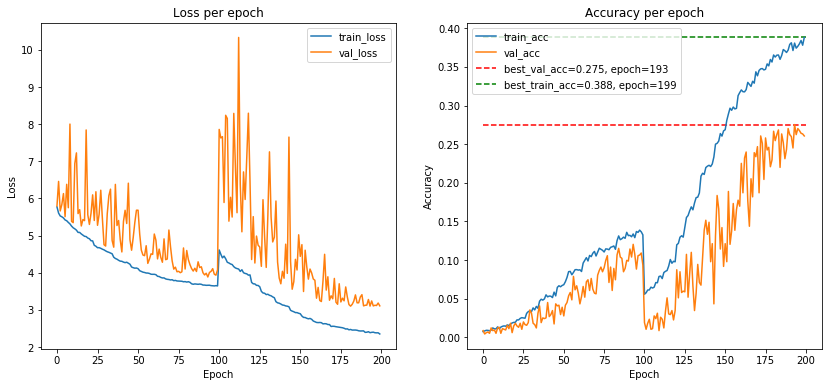

In [44]:
plot_train_val_curves('./model_sigmoid.pth', figsize=(14,6))

Arriba están las curvas de loss por epoch y accuracy por epoch para entrenamiento y validación, luego de haber entrenado el modelo por 200 épocas. Lo primero a destacar es lo mucho más lento que resulta usar Sigmoid en lugar de ReLu. En la actividad 1 el modelo alcanzó más de 40% de precisión en validación por la época 60, mientras que acá el modelo a lo sumo alcanzó 27.5% en validación recién en la época 193. Además, la precisión en el set de train es pésima, tan solo 38.8% de precisión en la época 199, mientras que en la actividad 1 el modelo alcanzó 99.8% en la época 81. El cambio abrupto en las curvas hacia la época 100 se debe que probé correr 100 épocas más con un learning rate inicial más alto (para acelerar el entrenamiento), aunque como vemos a la larga no ayudó mucho.

In [45]:
test_accuracy = test_model(resnet50_model, './model_sigmoid.pth', dataloaders['test'], dataset_sizes['test'], device)

In [46]:
test_accuracy

0.27155172413793105

Como vemos, en el set de test el resultado del mejor modelo es 27.16%, muy cercano y consistente con el 27.5% obtenido en validación. Esto confirma que el modelo generaliza con un accuracy entorno al 27% a imágenes de la misma distribución pero que no ha visto durante entrenamiento.